In [ ]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from keras.layers import LeakyReLU
from tensorflow.keras.optimizers import SGD
import numpy.linalg as LA
from sklearn import datasets, svm, metrics
import cv2

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
# Connect GDrive
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!ls gdrive/MyDrive/CSC2515_Project/data/out

test  train  valid


In [ ]:
# setting data paths
ROOT = "gdrive/MyDrive/CSC2515_Project/"
data = "gdrive/MyDrive/CSC2515_Project/data/out"

In [ ]:
from PIL import Image

In [ ]:
#function to load images into dataframe
def loaddata(rootdir):
    import os
    imagelist = []
    for (dirpath,dirnames,filenames) in os.walk(rootdir,followlinks=True):
      for file in filenames:
        if '.jpeg' in file:
          datalabel = dirpath.split('/')[-2]
          if (dirpath.split('/')[-1]=='normal'):
            classlabel = 0
          elif (dirpath.split('/')[-1]=='pneumonia'):
            classlabel = 1
          else:
            classlabel = 2
          imagelist.append((dirpath+'/'+ file,datalabel,classlabel))
    return pd.DataFrame(imagelist,columns=['image','data','class'])

In [ ]:
#flatten images to array with additional preprocessing
def flatImages(dataset,selectedLabels):
    vals =[]
    for i in range(len(dataset.values)):
        imgpath = dataset.iloc[i].image
        img = Image.open(imgpath).convert('L') #Luminance or brightness 
        img = img.resize((128,128), Image.ANTIALIAS) #reshape 
        img = np.array(img)
        vmax = img.max()
        vmin = img.min()
        threshold = vmin + 0.9 * (vmax - vmin)
        _, thres = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)
        equalized = cv2.equalizeHist(img)
        vals.append(equalized)
    datasetlabels = dataset.loc[:,dataset.columns == 'class']
    trainData= np.array(vals)
    trainlabel= np.array(datasetlabels)
    idx = [k for k in range(len(trainlabel)) if trainlabel[k] in selectedLabels]
    N = len(idx)
    X = np.zeros((N, 128 * 128), dtype=np.uint8)
    T = np.zeros((N, 1), dtype=np.uint8)
    for i in range(N):
        T[i] = trainlabel[idx[i]]
    return trainData,T

In [ ]:
train = loaddata('gdrive/MyDrive/CSC2515_Project/data/out/train')
valid = loaddata('gdrive/MyDrive/CSC2515_Project/data/out/valid')
test = loaddata('gdrive/MyDrive/CSC2515_Project/data/out/test')

from sklearn.utils import shuffle

train = shuffle(train)
valid = shuffle(valid)
test = shuffle(valid)

print(train.shape)
print(valid.shape)
print(test.shape)

train['class'].unique()

(685, 3)
(399, 3)
(399, 3)


array([1, 2, 0])

In [ ]:
train['class'].unique()

array([1, 2, 0])

In [ ]:
X_train,Y_train = flatImages(train, selectedLabels=[0,1,2])
X_test,Y_test = flatImages(test, selectedLabels=[0,1,2])
X_valid,Y_valid = flatImages(valid, selectedLabels=[0,1,2])

X_train = X_train.reshape(-1,X_train.shape[1]*X_train.shape[2])
X_test = X_test.reshape(-1,X_test.shape[1]*X_test.shape[2])
X_valid = X_valid.reshape(-1,X_valid.shape[1]*X_valid.shape[2])

SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

def svm_model(feature_vector_x, feature_vector_y):
  params = {'C':[0.01, 0.1, 1, 10, 100],
       'kernel':['rbf', 'poly', 'linear', 'sigmoid']}
  classifier_linear = GridSearchCV(SVC(), params, cv=10)
  classifier_linear.fit(feature_vector_x, feature_vector_y)
  print('train score:', metrics.accuracy_score(classifier_linear.predict(feature_vector_x), feature_vector_y))
  print(classifier_linear.best_params_)
  return classifier_linear

In [ ]:
import numpy as np
import scipy.stats


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

def average_performance(iter, X_train, Y_train, X_test, Y_test):
    acc= []
    prec = []
    rec = []
    f1 = []
    for i in range(iter):
        clf = svm_model(X_train, Y_train.reshape(-1,))
        Y_pred = clf.predict(X_test)
        acc.append(metrics.accuracy_score(Y_test, Y_pred))
        prec.append(metrics.precision_score(Y_test, Y_pred, average='macro'))
        rec.append(metrics.recall_score(Y_test,Y_pred, average='macro'))
        f1.append(metrics.f1_score(Y_test, Y_pred, average='macro'))

    m_acc, h_acc = mean_confidence_interval(acc, confidence=0.95)
    m_prec, h_prec = mean_confidence_interval(prec, confidence = 0.95)
    m_rec, h_rec = mean_confidence_interval(rec, confidence = 0.95)
    m_f1, h_f1 = mean_confidence_interval(f1, confidence=  0.95)

    print("Mean Accuracy: ", m_acc, "+-", h_acc)
    print("Mean Precision: ", m_prec, "+-", h_prec)
    print("Mean Recall: ", m_rec, "+-", h_rec)
    print("Mean F1: ", m_f1, "+-", h_f1)

*Test accuracy*

In [ ]:
average_performance(5, X_train, Y_train, X_test, Y_test)

train score: 1.0
{'C': 10, 'kernel': 'rbf'}
train score: 1.0
{'C': 10, 'kernel': 'rbf'}
train score: 1.0
{'C': 10, 'kernel': 'rbf'}
train score: 1.0
{'C': 10, 'kernel': 'rbf'}
train score: 1.0
{'C': 10, 'kernel': 'rbf'}
Mean Accuracy:  0.982456140350877 +- 1.5412366411992055e-16
Mean Precision:  0.9721517307724203 +- 1.5412366411992055e-16
Mean Recall:  0.9674638908934977 +- 0.0
Mean F1:  0.9697811401665357 +- 1.5412366411992055e-16


XGBoost

In [ ]:
# XGBoost
from xgboost import XGBClassifier

def xgboost_model(feature_vector_x, feature_vector_y):
  xgb = XGBClassifier(random_state=42, seed=2, colsample_bytree=0.6, subsample=0.7)
  param_grid = {
     'xgb__n_estimators': [1, 5, 10, 50]}
  grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid, cv = 5, 
                             n_jobs = 1, verbose = 0, return_train_score=True)

  grid_search.fit(feature_vector_x, feature_vector_y)
  print(grid_search.best_params_)

  print('train score:', metrics.accuracy_score(grid_search.predict(feature_vector_x), feature_vector_y))

  return grid_search

*Test accuracy*

In [ ]:
def average_performance(iter, X_train, Y_train, X_test, Y_test):
    acc= []
    prec = []
    rec = []
    f1 = []
    for i in range(iter):
        clf = xgboost_model(X_train, Y_train.reshape(-1,))
        Y_pred = clf.predict(X_test)
        acc.append(metrics.accuracy_score(Y_test, Y_pred))
        prec.append(metrics.precision_score(Y_test, Y_pred, average='macro'))
        rec.append(metrics.recall_score(Y_test,Y_pred, average='macro'))
        f1.append(metrics.f1_score(Y_test, Y_pred, average='macro'))

    m_acc, h_acc = mean_confidence_interval(acc, confidence=0.95)
    m_prec, h_prec = mean_confidence_interval(prec, confidence = 0.95)
    m_rec, h_rec = mean_confidence_interval(rec, confidence = 0.95)
    m_f1, h_f1 = mean_confidence_interval(f1, confidence=  0.95)

    print("Mean Accuracy: ", m_acc, "+-", h_acc)
    print("Mean Precision: ", m_prec, "+-", h_prec)
    print("Mean Recall: ", m_rec, "+-", h_rec)
    print("Mean F1: ", m_f1, "+-", h_f1)

average_performance(5, X_train, Y_train, X_test, Y_test)

{'xgb__n_estimators': 1}
train score: 1.0
{'xgb__n_estimators': 1}
train score: 1.0
{'xgb__n_estimators': 1}
train score: 1.0
{'xgb__n_estimators': 1}
train score: 1.0
{'xgb__n_estimators': 1}
train score: 1.0
Mean Accuracy:  0.9398496240601503 +- 1.5412366411992055e-16
Mean Precision:  0.9763313609467457 +- 1.5412366411992055e-16
Mean Recall:  0.8405172413793103 +- 1.5412366411992055e-16
Mean F1:  0.8926251662447982 +- 0.0


DT

In [ ]:
# DT
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

def dt_model(feature_vector_x, feature_vector_y):
  dtclassifier = DecisionTreeClassifier(criterion='entropy', max_depth=None)
  scores = cross_val_score(dtclassifier, feature_vector_x, feature_vector_y, cv = 10)
  dtclassifier.fit(feature_vector_x, feature_vector_y)
  print('train score:', metrics.accuracy_score(dtclassifier.predict(feature_vector_x), feature_vector_y))
  return dtclassifier

*Test accuracy*

In [ ]:
def average_performance(iter, X_train, Y_train, X_test, Y_test):
    acc= []
    prec = []
    rec = []
    f1 = []
    for i in range(iter):
        clf = dt_model(X_train, Y_train.reshape(-1,))
        Y_pred = clf.predict(X_test)
        acc.append(metrics.accuracy_score(Y_test, Y_pred))
        prec.append(metrics.precision_score(Y_test, Y_pred, average='macro'))
        rec.append(metrics.recall_score(Y_test,Y_pred, average='macro'))
        f1.append(metrics.f1_score(Y_test, Y_pred, average='macro'))

    m_acc, h_acc = mean_confidence_interval(acc, confidence=0.95)
    m_prec, h_prec = mean_confidence_interval(prec, confidence = 0.95)
    m_rec, h_rec = mean_confidence_interval(rec, confidence = 0.95)
    m_f1, h_f1 = mean_confidence_interval(f1, confidence=  0.95)

    print("Mean Accuracy: ", m_acc, "+-", h_acc)
    print("Mean Precision: ", m_prec, "+-", h_prec)
    print("Mean Recall: ", m_rec, "+-", h_rec)
    print("Mean F1: ", m_f1, "+-", h_f1)

average_performance(5, X_train, Y_train, X_test, Y_test)

train score: 1.0
train score: 1.0
train score: 1.0
train score: 1.0
train score: 1.0
Mean Accuracy:  0.8586466165413533 +- 0.008114946289266674
Mean Precision:  0.7528745510840179 +- 0.018076356018017485
Mean Recall:  0.7472388691914279 +- 0.023573719811971514
Mean F1:  0.7419582642470821 +- 0.013158850677845158


Basic 2D CNN

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import tensorflow as tf

batch_size = 256
num_classes = 3
epochs = 10

CONV1 = 64
CONV2 = 128
DENSE = 128
KERNEL_CONV=3
KERNEL_POOL=2
ACTIVATION='relu'
DROPOUT = 0.1
OPTIMIZER='adam'

#input image dimensions
img_rows, img_cols = 128, 128

model = Sequential()
model.add(Conv2D(CONV1, kernel_size=(KERNEL_CONV, KERNEL_CONV),
                 activation=ACTIVATION,
                 input_shape=(img_rows,img_cols,1)))
model.add(MaxPooling2D((KERNEL_POOL, KERNEL_POOL)))
model.add(Conv2D(CONV2, (KERNEL_CONV, KERNEL_CONV), activation='relu'))
model.add(Flatten())
model.add(Dense(DENSE, activation=ACTIVATION, name ='my_dense'))
model.add(Dropout(DROPOUT))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer = OPTIMIZER, metrics = ['accuracy'])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 128)       73856     
                                                                 
 flatten (Flatten)           (None, 476288)            0         
                                                                 
 my_dense (Dense)            (None, 128)               60964992  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                        

In [ ]:
model.save("my_h5_model.h5")

In [ ]:
def average_performance(iter, X_train, Y_train, X_test, Y_test):
    acc= []
    prec = []
    rec = []
    f1 = []
    for i in range(iter):
        history = model.fit(X_train.reshape(X_train.shape[0],img_rows,img_cols,1),
                    tf.keras.utils.to_categorical(Y_train, num_classes),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.20)
        Y_pred = np.argmax(model.predict(X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)), axis=1)        
        acc.append(metrics.accuracy_score(Y_test, Y_pred))
        prec.append(metrics.precision_score(Y_test, Y_pred, average='macro'))
        rec.append(metrics.recall_score(Y_test,Y_pred, average='macro'))
        f1.append(metrics.f1_score(Y_test, Y_pred, average='macro'))

    m_acc, h_acc = mean_confidence_interval(acc, confidence=0.95)
    m_prec, h_prec = mean_confidence_interval(prec, confidence = 0.95)
    m_rec, h_rec = mean_confidence_interval(rec, confidence = 0.95)
    m_f1, h_f1 = mean_confidence_interval(f1, confidence=  0.95)

    print("Mean Accuracy: ", m_acc, "+-", h_acc)
    print("Mean Precision: ", m_prec, "+-", h_prec)
    print("Mean Recall: ", m_rec, "+-", h_rec)
    print("Mean F1: ", m_f1, "+-", h_f1)

average_performance(10, X_train, Y_train, X_test, Y_test)

Epoch 1/10
3/3 [==============================] - 1s 362ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.6966 - val_accuracy: 0.9270
Epoch 2/10
3/3 [==============================] - 1s 350ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.5289 - val_accuracy: 0.9416
Epoch 3/10
3/3 [==============================] - 1s 339ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.5282 - val_accuracy: 0.9343
Epoch 4/10
3/3 [==============================] - 1s 337ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.5525 - val_accuracy: 0.9416
Epoch 5/10
3/3 [==============================] - 1s 340ms/step - loss: 4.0627e-04 - accuracy: 1.0000 - val_loss: 0.5924 - val_accuracy: 0.9416
Epoch 6/10
3/3 [==============================] - 1s 344ms/step - loss: 8.2179e-05 - accuracy: 1.0000 - val_loss: 0.6341 - val_accuracy: 0.9416
Epoch 7/10
3/3 [==============================] - 1s 339ms/step - loss: 4.5792e-04 - accuracy: 1.0000 - val_loss: 0.6468 - val_accuracy: 0.9416
Epoch 8/

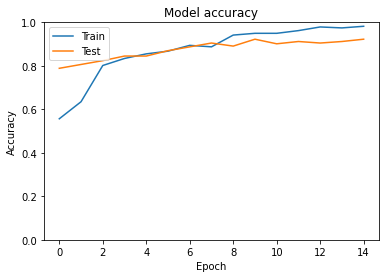

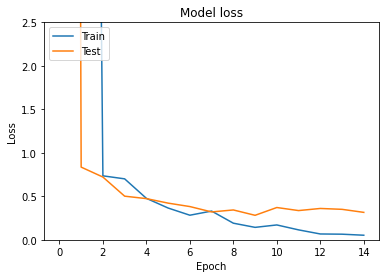

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.ylim([0, 1])
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.ylim([0, 2.5])
plt.show()

*Intermediate Layer*

In [ ]:
from keras.models import Model
layer_name='my_dense'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)

intermediate_layer_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 128)       73856     
                                                                 
 flatten (Flatten)           (None, 476288)            0         
                                                                 
 my_dense (Dense)            (None, 128)               60964992  
                                                             

In [ ]:
intermediate_output_X_train = intermediate_layer_model.predict(X_train.reshape(X_train.shape[0],img_rows,img_cols,1)) 
intermediate_output_X_train = pd.DataFrame(data=intermediate_output_X_train)

intermediate_output_X_valid = intermediate_layer_model.predict(X_valid.reshape(X_valid.shape[0],img_rows,img_cols,1)) 
intermediate_output_X_valid = pd.DataFrame(data=intermediate_output_X_valid)

intermediate_output_X_test = intermediate_layer_model.predict(X_test.reshape(X_test.shape[0],img_rows,img_cols,1)) 
intermediate_output_X_test = pd.DataFrame(data=intermediate_output_X_test)

*XGBOOST*

*Test accuracy*

In [ ]:
def average_performance(iter, X_train, Y_train, X_test, Y_test):
    acc= []
    prec = []
    rec = []
    f1 = []
    for i in range(iter):
        clf = xgboost_model(X_train, Y_train)
        Y_pred = clf.predict(X_test)
        acc.append(metrics.accuracy_score(Y_test, Y_pred))
        prec.append(metrics.precision_score(Y_test, Y_pred, average='macro'))
        rec.append(metrics.recall_score(Y_test,Y_pred, average='macro'))
        f1.append(metrics.f1_score(Y_test, Y_pred, average='macro'))

    m_acc, h_acc = mean_confidence_interval(acc, confidence=0.95)
    m_prec, h_prec = mean_confidence_interval(prec, confidence = 0.95)
    m_rec, h_rec = mean_confidence_interval(rec, confidence = 0.95)
    m_f1, h_f1 = mean_confidence_interval(f1, confidence=  0.95)

    print("Mean Accuracy: ", m_acc, "+-", h_acc)
    print("Mean Precision: ", m_prec, "+-", h_prec)
    print("Mean Recall: ", m_rec, "+-", h_rec)
    print("Mean F1: ", m_f1, "+-", h_f1)

average_performance(20, intermediate_output_X_train, Y_train.ravel(), intermediate_output_X_test, Y_test.ravel())

{'xgb__n_estimators': 1}
train score: 0.9985401459854014
{'xgb__n_estimators': 1}
train score: 0.9985401459854014
{'xgb__n_estimators': 1}
train score: 0.9985401459854014
{'xgb__n_estimators': 1}
train score: 0.9985401459854014
{'xgb__n_estimators': 1}
train score: 0.9985401459854014
{'xgb__n_estimators': 1}
train score: 0.9985401459854014
{'xgb__n_estimators': 1}
train score: 0.9985401459854014
{'xgb__n_estimators': 1}
train score: 0.9985401459854014
{'xgb__n_estimators': 1}
train score: 0.9985401459854014
{'xgb__n_estimators': 1}
train score: 0.9985401459854014
{'xgb__n_estimators': 1}
train score: 0.9985401459854014
{'xgb__n_estimators': 1}
train score: 0.9985401459854014
{'xgb__n_estimators': 1}
train score: 0.9985401459854014
{'xgb__n_estimators': 1}
train score: 0.9985401459854014
{'xgb__n_estimators': 1}
train score: 0.9985401459854014
{'xgb__n_estimators': 1}
train score: 0.9985401459854014
{'xgb__n_estimators': 1}
train score: 0.9985401459854014
{'xgb__n_estimators': 1}
train 

*SVM*

*Test accuracy*

In [ ]:
def average_performance(iter, X_train, Y_train, X_test, Y_test):
    acc= []
    prec = []
    rec = []
    f1 = []
    for i in range(iter):
        clf = svm_model(X_train, Y_train.ravel())
        Y_pred = clf.predict(X_test)
        acc.append(metrics.accuracy_score(Y_test, Y_pred))
        prec.append(metrics.precision_score(Y_test, Y_pred, average='macro'))
        rec.append(metrics.recall_score(Y_test,Y_pred, average='macro'))
        f1.append(metrics.f1_score(Y_test, Y_pred, average='macro'))

    m_acc, h_acc = mean_confidence_interval(acc, confidence=0.95)
    m_prec, h_prec = mean_confidence_interval(prec, confidence = 0.95)
    m_rec, h_rec = mean_confidence_interval(rec, confidence = 0.95)
    m_f1, h_f1 = mean_confidence_interval(f1, confidence=  0.95)

    print("Mean Accuracy: ", m_acc, "+-", h_acc)
    print("Mean Precision: ", m_prec, "+-", h_prec)
    print("Mean Recall: ", m_rec, "+-", h_rec)
    print("Mean F1: ", m_f1, "+-", h_f1)

average_performance(20, intermediate_output_X_train, Y_train.ravel(), intermediate_output_X_test, Y_test.ravel())

train score: 0.9912408759124087
{'C': 1, 'kernel': 'rbf'}
train score: 0.9912408759124087
{'C': 1, 'kernel': 'rbf'}
train score: 0.9912408759124087
{'C': 1, 'kernel': 'rbf'}
train score: 0.9912408759124087
{'C': 1, 'kernel': 'rbf'}
train score: 0.9912408759124087
{'C': 1, 'kernel': 'rbf'}
train score: 0.9912408759124087
{'C': 1, 'kernel': 'rbf'}
train score: 0.9912408759124087
{'C': 1, 'kernel': 'rbf'}
train score: 0.9912408759124087
{'C': 1, 'kernel': 'rbf'}
train score: 0.9912408759124087
{'C': 1, 'kernel': 'rbf'}
train score: 0.9912408759124087
{'C': 1, 'kernel': 'rbf'}
train score: 0.9912408759124087
{'C': 1, 'kernel': 'rbf'}
train score: 0.9912408759124087
{'C': 1, 'kernel': 'rbf'}
train score: 0.9912408759124087
{'C': 1, 'kernel': 'rbf'}
train score: 0.9912408759124087
{'C': 1, 'kernel': 'rbf'}
train score: 0.9912408759124087
{'C': 1, 'kernel': 'rbf'}
train score: 0.9912408759124087
{'C': 1, 'kernel': 'rbf'}
train score: 0.9912408759124087
{'C': 1, 'kernel': 'rbf'}
train score: 0